In [14]:
OUTDATED_IGNORE=1

import pandas as pd 
import pingouin as pg 
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import matplotlib.ticker as ticker

In [13]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color='darkgray')
    plt.setp(bp['caps'], color='darkgray')
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], color='darkgray', alpha=0.5)

## READ IN DATA 

In [24]:
#df = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_diffusion_metrics.csv', index_col=0)
df = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_diffusion_metrics_median.csv', index_col=0)

info = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
df = pd.merge(df, info, on=['subject_id'])
df['group'] = 'FT'
df.loc[df['GA_birth'] < 37, 'group'] = 'PT'

with open('../../DerivedData/cohorts_subjects_list.pickle', 'rb') as handle:
    cohorts = pickle.load(handle)

# Inter-hemispheric differences 

In [25]:
### cohort A 
df = df[df.subject_id.isin(cohorts['A'])]

In [26]:
metrics = ['FA', 'L1', 'RD', 'MD']
hemispheres = ['left', 'right']

print('Cohort A')
for metric in metrics:
    print('Global {}:'.format(metric))
    for hemi in hemispheres:
        label = '{}_{}'.format(hemi, metric)
        print('{}: {:.6f} ({:.6f}) mean (std); {:.6f} [{:.6f},{:.6f}] median [range]'.format(
                 hemi, np.mean(df[label].values), np.std(df[label].values), 
            np.median(df[label].values), np.min(df[label].values), np.max(df[label].values)
                        ))

Cohort A
Global FA:
left: 0.076585 (0.004759) mean (std); 0.076175 [0.064786,0.099380] median [range]
right: 0.076650 (0.004762) mean (std); 0.076300 [0.064025,0.099729] median [range]
Global L1:
left: 0.001210 (0.000035) mean (std); 0.001206 [0.001115,0.001356] median [range]
right: 0.001204 (0.000036) mean (std); 0.001201 [0.001117,0.001346] median [range]
Global RD:
left: 0.001025 (0.000027) mean (std); 0.001027 [0.000932,0.001095] median [range]
right: 0.001021 (0.000027) mean (std); 0.001021 [0.000941,0.001089] median [range]
Global MD:
left: 0.001092 (0.000028) mean (std); 0.001093 [0.001001,0.001164] median [range]
right: 0.001087 (0.000028) mean (std); 0.001086 [0.001006,0.001164] median [range]


## Compare global diffusion metric between hemispheres (paired t-test + FDR correction)

In [27]:
df = df.dropna()
res = pd.DataFrame()

for i, metric in enumerate(metrics):
    test = pg.ttest(df['left_{}'.format(metric)].values, df['right_{}'.format(metric)].values, paired=True)
    res.loc[i, 'metric'] = metric
    res.loc[i, 'T'] = test['T'].values[0]
    res.loc[i, 'p-val'] = np.float32(test['p-val'].values[0])
    
res['p-val'] = pg.multicomp(res['p-val'].values, method='fdr_bh')[1]
res

,metric,T,p-val
0,FA,-0.626048,5.317692e-01
1,L1,7.922131,1.940508e-13
2,RD,6.466084,5.574691e-10
3,MD,7.264868,6.742588e-12


Significant differences exist between the two hemispheres except for the FA!

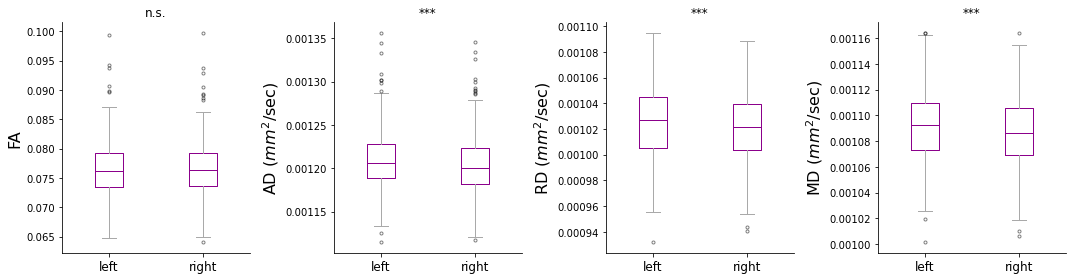

In [28]:
fig, axs = plt.subplots(1,4,  figsize=(15,4))

for i, metric in enumerate(metrics):
    cols =  [col for col in df.columns if metric in col]
    bpl = axs[i].boxplot(df[cols], positions=np.arange(len(cols)) - 0.2, 
                    sym='.', widths=0.3, vert=True, showfliers=True, labels=['left', 'right'])
    set_box_color(bpl, 'darkmagenta')
    
    
    if metric in ['RD', 'MD']:
        label = metric + ' ($mm^2$/sec)'
    elif metric == 'L1':
        label = 'AD ($mm^2$/sec)'
    else: 
        label = metric
        
    axs[i].set_ylabel(label, fontsize=16)
    axs[i].tick_params(axis='x', which='major', labelsize=12)
    
    if res[res['metric']== metric]['p-val'].values[0] < 0.001:
        l = '***'
    elif res[res['metric']== metric]['p-val'].values[0] < 0.01:
        l= '**'
    elif res[res['metric']== metric]['p-val'].values[0] < 0.05:  
        l='*'
    else: 
        l = 'n.s.'
    axs[i].set_title(l)

for ax in axs.ravel():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.set_facecolor("white")    
plt.tight_layout()
plt.show()

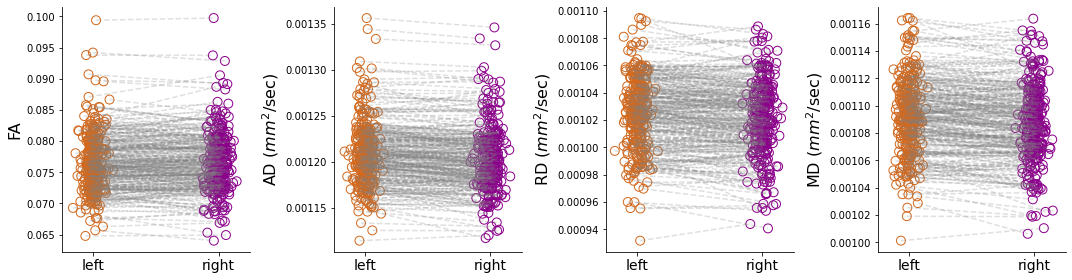

In [29]:
fig, axs = plt.subplots(1,4,  figsize=(15,4))

for i, metric in enumerate(metrics):
    cols =  [col for col in df.columns if metric in col]
    
    y1 = np.random.normal(0, 0.05, size=len(df[cols[0]].values))
    axs[i].scatter(  y1, df[cols[0]].values, marker= 'o', s=80,
                    facecolors='none', edgecolors = 'chocolate')
    
    y2 = np.random.normal(1, 0.05, size=len(df[cols[1]].values))
    axs[i].scatter(  y2, df[cols[1]].values, marker= 'o', s=80,
                    facecolors='none', edgecolors = 'darkmagenta')
    
    plt.sca(axs[i])
    plt.xticks([0,1],['left', "right"], fontsize=14)

    if metric in ['RD', 'MD']:
        label = metric + ' ($mm^2$/sec)'
    elif metric == 'L1':
        label = 'AD ($mm^2$/sec)'
    else: 
        label = metric
        
    axs[i].set_ylabel(label, fontsize=16)
    
    for p in range(len(y1)):
        axs[i].plot([y1[p],y2[p]], [df[cols[0]].values[p], df[cols[1]].values[p]], '--', color='gray', alpha=0.25)

    axs[i].set_xlim(-0.25,1.25)
for ax in axs.ravel():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.set_facecolor("white")    
plt.tight_layout()  
plt.show()

## Global metrics between PT and FT (t-test, FDR correction)

In [30]:
i = 0

t_res = pd.DataFrame()
for metric in metrics:
    for hemi in hemispheres:
        
        label = '{}_{}'.format(hemi, metric)
        test = pg.ttest(df[df['group'] == 'PT'][label].values, 
                       df[df['group'] == 'FT'][label].values)
        t_res.loc[i, 'metric'] = metric 
        t_res.loc[i, 'hemi'] = hemi
        t_res.loc[i, 'T'] = test['T'].values[0]
        t_res.loc[i, 'p-val'] = np.float32(test['p-val'].values[0])
        
        i= i+1
t_res['p-val'] = pg.multicomp(t_res['p-val'].values, method='fdr_bh')[1]

In [39]:
pd.pivot_table(t_res, values=['T', 'p-val'], index=['metric'], columns=['hemi'])

T                   p-val              
hemi        left     right          left         right
metric                                                
FA      1.536090  1.661294  1.313097e-01  1.181434e-01
L1      9.392573  9.421372  6.751297e-12  6.751297e-12
MD      7.874066  7.892337  3.209610e-10  3.209610e-10
RD      4.902283  4.988406  1.277045e-05  1.137833e-05

## Global metric with PMA at scan (linear regression, corrected for GA birth)

In [41]:
i=0
res_reg = pd.DataFrame()
for metric in metrics:
    for hemi in hemispheres:
        #correct for age at birth 
        lm = pg.linear_regression(df['{}_{}'.format(hemi, metric)], df['GA_birth'])
        # regression with PMA at scan 
        result = pg.linear_regression(lm.residuals_, df['PMA_scan'])
        
        res_reg.loc[i, 'metric'] = metric
        res_reg.loc[i, 'hemi'] = hemi
        res_reg.loc[i, 'coef'] = np.float32(result.coef[1])
        res_reg.loc[i, 'p-val'] = np.float64(result.pval[1])
        i = i+1
        
res_reg['p-val'] = pg.multicomp(res_reg['p-val'].values, method='fdr_bh')[1]

In [43]:
pd.pivot_table(res_reg, values=['coef', 'p-val'], index=['metric'], columns=['hemi'])

coef                   p-val              
hemi        left     right          left         right
metric                                                
FA      0.829902  0.832413  6.982312e-65  6.775675e-65
L1      0.731493  0.731568  3.163181e-18  2.499964e-18
MD      0.836540  0.830344  2.801680e-38  5.418886e-38
RD      0.860692  0.854349  3.696951e-55  2.234943e-54

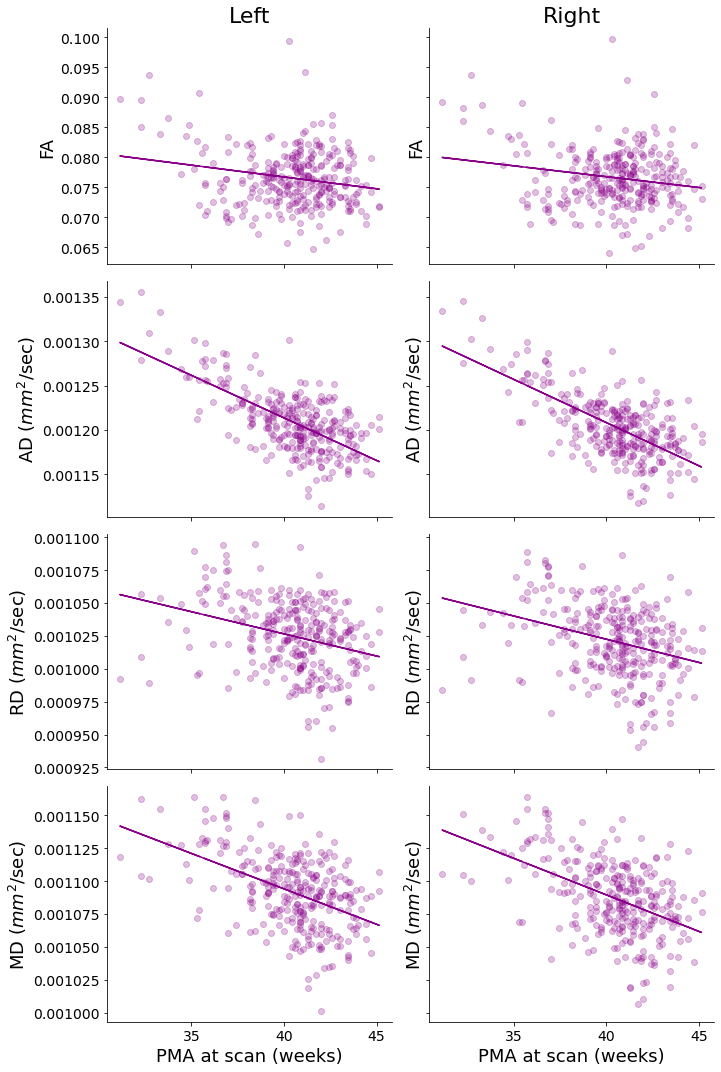

In [44]:
fig, axs = plt.subplots(4,2, figsize=(10,15), sharex=True, sharey='row')

cols =  [col for col in df.columns if 'left' in col]
for i, col in enumerate(cols): 
    axs[i,0].scatter( df['PMA_scan'].values, df[col].values, c='darkmagenta', alpha=0.25)
    
    if col.split('_')[1] in ['RD', 'MD']:
        label = col.split('_')[1] + ' ($mm^2$/sec)'
    elif col.split('_')[1] == 'L1':
        label = 'AD ($mm^2$/sec)'
    else: 
        label = col.split('_')[1]
    axs[i,0].set_ylabel(label, fontsize=18)
    axs[i,0].tick_params(axis='both', which='major', labelsize=14)
    
    m, b = np.polyfit(df['PMA_scan'].values, df[col].values, deg=1)
    axs[i,0].plot(df['PMA_scan'].values, b + m*df['PMA_scan'].values, linestyle='-', c='darkmagenta')
    
    
cols =  [col for col in df.columns if 'right' in col]
for i, col in enumerate(cols): 
    axs[i,1].scatter( df['PMA_scan'].values, df[col].values, c='darkmagenta', alpha=0.25)
    if col.split('_')[1] != 'FA' and col.split('_')[1] != 'L1':
        label = col.split('_')[1] + ' ($mm^2$/sec)'
    elif col.split('_')[1] == 'L1':
        label = 'AD ($mm^2$/sec)'
    else: 
        label = col.split('_')[1]
    axs[i,1].set_ylabel(label, fontsize=18)
    axs[i,1].tick_params(axis='both', which='major', labelsize=14)
    
    m, b = np.polyfit(df['PMA_scan'].values, df[col].values, deg=1)
    axs[i,1].plot(df['PMA_scan'].values, b + m*df['PMA_scan'].values, linestyle='-', c='darkmagenta')
    
axs[0,0].set_title('Left', fontsize=22)
axs[0,1].set_title('Right', fontsize=22)
axs[-1,0].set_xlabel('PMA at scan (weeks)', fontsize=18)
axs[-1,1].set_xlabel('PMA at scan (weeks)', fontsize=18)


for ax in axs.ravel():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


fig.set_facecolor("white")
plt.tight_layout()
#plt.savefig('../../Results/figures/linear_regression_global_diffusion_metrics_with_PMAatScan.jpg', dpi=500)
plt.show()

From FA the inflection point is quite visible within the hemispheres. It looks normal although the results are quite strange!

## Global metrics with Outcomes

In [52]:
scores = ['Cognitive Score', 'Language Score', 'Motor Score']

i=0
res_reg = pd.DataFrame()
for metric in metrics:
    for hemi in hemispheres:
        for score in scores:
            result = pg.corr(df['{}_{}'.format(hemi, metric)].values,
                        df[score].values)
        
        
            res_reg.loc[i, 'metric'] = metric
            res_reg.loc[i, 'hemi'] = hemi
            res_reg.loc[i, 'score'] = score 
            res_reg.loc[i, 'R'.format(score)] = np.round(np.float32(result.r),2)
            res_reg.loc[i, 'p-val'.format(score)] = np.float64(result['p-val'])
        #res_reg.loc[i, 'p-val'] = np.float64(result.pval[1])
            i = i+1
  

#labels = [label+'_p-val' for label in scores]

pvals = pg.multicomp(res_reg['p-val'].values.ravel(), method='fdr_bh')[1]
pvals = pvals.reshape(np.shape(res_reg['p-val'].values))
res_reg['p-val'] = pvals

In [55]:

pd.pivot_table(res_reg, values=['R', 'p-val'], index=['metric'], columns=[ 'score', 'hemi'])

R                                               \
score  Cognitive Score       Language Score       Motor Score         
hemi              left right           left right        left right   
metric                                                                
FA               -0.09 -0.11          -0.13 -0.11        0.00  0.00   
L1                0.02  0.02           0.02  0.01       -0.09 -0.07   
MD                0.04  0.04           0.03  0.03       -0.09 -0.06   
RD                0.05  0.06           0.05  0.04       -0.08 -0.05   

                 p-val                                                 \
score  Cognitive Score           Language Score           Motor Score   
hemi              left     right           left     right        left   
metric                                                                  
FA            0.579832  0.519804       0.519804  0.519804    0.995341   
L1            0.894554  0.894554       0.894554  0.894554    0.579832   
MD            0.744660  0.744660       0.796843  0.877671    0.579832   
RD            0.743378  0.743378       0.744660  0.744660    0.618034   

                  
score             
hemi       right  
metric            
FA      0.995341  
L1      0.743378  
MD      0.743378  
RD      0.743378

# ENTIRE BRAIN 

In [56]:
metrics = ['FA', 'L1', 'RD', 'MD']
hemispheres = ['left', 'right']
for metric in metrics:
    for i, row in df.iterrows():
        df.loc[i,metric] = np.mean([row['left_{}'.format(metric)], 
                                   row['right_{}'.format(metric)]])

In [58]:
for i, cohort in enumerate(cohorts.keys()):
    print('Cohort {}:'.format(cohort))
    
    sub_df = df[df.subject_id.isin(cohorts[cohort])]
    
    for label in metrics:
        print('Global {}; {:.6f} ({:.6f}); mean (std); {:.6f} [{:.6f},{:.6f}]; median [range]'.format(
                label, np.mean(sub_df[label].values), np.std(sub_df[label].values), 
            np.median(sub_df[label].values), np.min(sub_df[label].values), np.max(sub_df[label].values)
        
                        ))

Cohort A:
Global FA; 0.076617 (0.004676); mean (std); 0.076160 [0.064856,0.099554]; median [range]
Global L1; 0.001207 (0.000035); mean (std); 0.001205 [0.001117,0.001351]; median [range]
Global RD; 0.001023 (0.000027); mean (std); 0.001025 [0.000938,0.001089]; median [range]
Global MD; 0.001090 (0.000028); mean (std); 0.001090 [0.001006,0.001159]; median [range]
Cohort B:
Global FA; 0.076794 (0.004816); mean (std); 0.076456 [0.064856,0.099554]; median [range]
Global L1; 0.001215 (0.000034); mean (std); 0.001210 [0.001125,0.001351]; median [range]
Global RD; 0.001028 (0.000026); mean (std); 0.001030 [0.000957,0.001089]; median [range]
Global MD; 0.001095 (0.000027); mean (std); 0.001097 [0.001019,0.001159]; median [range]
Cohort C:
Global FA; 0.076756 (0.004810); mean (std); 0.076414 [0.064856,0.099554]; median [range]
Global L1; 0.001216 (0.000034); mean (std); 0.001211 [0.001125,0.001351]; median [range]
Global RD; 0.001028 (0.000026); mean (std); 0.001030 [0.000957,0.001089]; median

## Global metric with PMA at scan (linear regression, corrected for GA birth)

In [65]:
res_reg = pd.DataFrame()
i=0
for f, cohort in enumerate(cohorts.keys()):
    #print('Cohort {}:'.format(cohort))
    sub_df = df[df.subject_id.isin(cohorts[cohort])]

    for metric in metrics:
        #correct for age at birth 
        lm = pg.linear_regression(sub_df[metric], sub_df['GA_birth'])
        # regression with PMA at scan 
        result = pg.linear_regression(lm.residuals_, sub_df['PMA_scan'])
        res_reg.loc[i, 'cohort'] = cohort
        res_reg.loc[i, 'metric'] = metric
        res_reg.loc[i, 'coef'] = np.float32(result.coef[1])
        res_reg.loc[i, 'p-val'] = np.float64(result.pval[1])
        i = i+1
        
    res_reg['p-val'] = pg.multicomp(res_reg['p-val'].values, method='fdr_bh')[1]


In [77]:
pd.pivot_table(res_reg,  index=['metric'], columns=[ 'cohort']).sort_index(axis=1)

coef                                       p-val                \
cohort         A         B         C         D             A             B   
metric                                                                       
FA      0.830626  0.751466  0.750631  0.705242  6.668733e-63  5.187639e-66   
L1      0.724856  0.737960  0.737529  0.656595  2.378850e-17  1.020517e-18   
MD      0.832812  0.782570  0.782193  0.737233  9.811375e-37  1.030394e-37   
RD      0.858202  0.783559  0.783016  0.747268  3.316592e-53  3.260975e-56   

                                    
cohort             C             D  
metric                              
FA      1.506587e-65  9.811375e-37  
L1      1.020517e-18  2.760349e-10  
MD      1.030394e-37  8.421188e-21  
RD      3.075248e-56  5.223150e-30

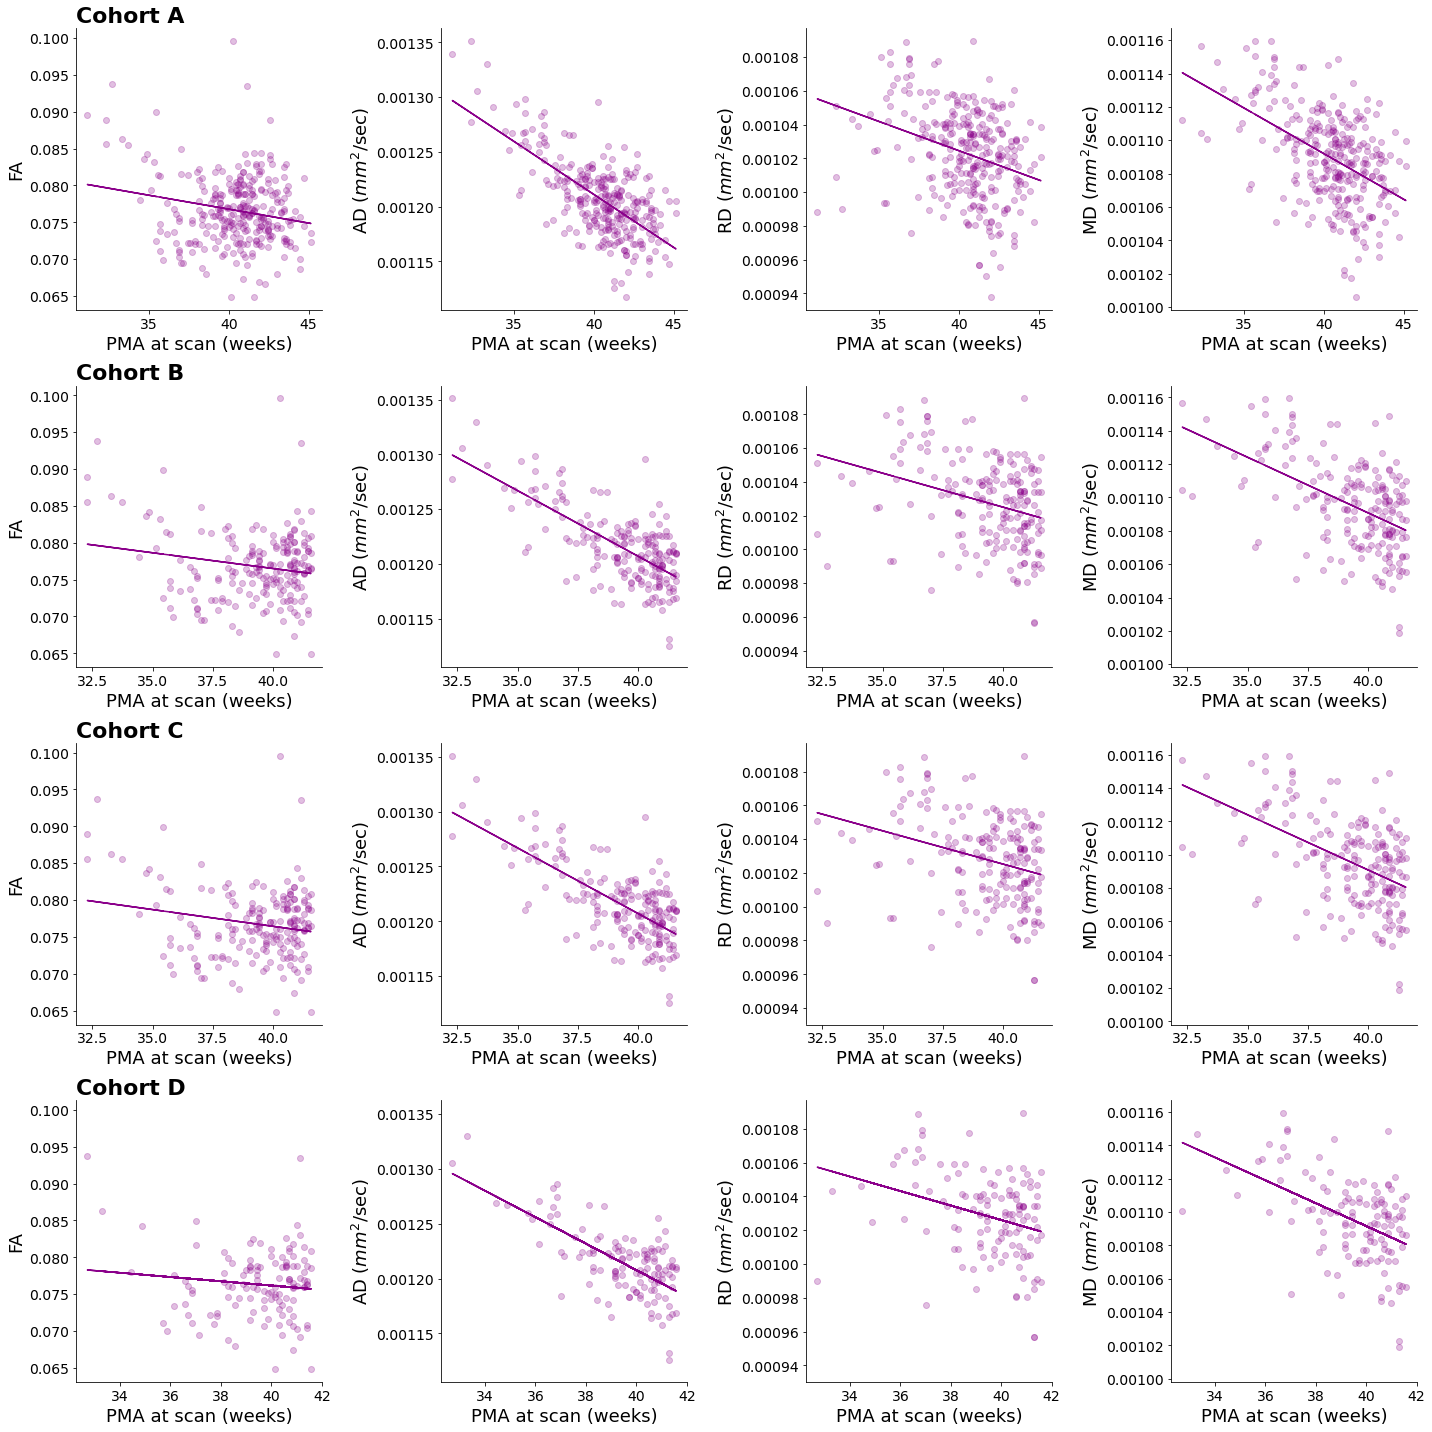

In [79]:
fig, axs = plt.subplots(4,4, figsize=(20,20), sharey='col')#, sharey='row')
#axs = axs.ravel()

for f, cohort in enumerate(cohorts.keys()):
    #print('Cohort {}:'.format(cohort))
    
    sub_df = df[df.subject_id.isin(cohorts[cohort])]
    

    for i, col in enumerate(metrics): 
        axs[f,i].scatter( sub_df['PMA_scan'].values, sub_df[col].values, c='darkmagenta', alpha=0.25)
    
        if col in ['RD', 'MD']:
            label = col + ' ($mm^2$/sec)'
        elif col == 'L1':
            label = 'AD ($mm^2$/sec)'
        else: 
            label = col
        axs[f,i].set_ylabel(label, fontsize=18)
        axs[f,i].tick_params(axis='both', which='major', labelsize=14)
    
        m, b = np.polyfit(sub_df['PMA_scan'].values, sub_df[col].values, deg=1)
        axs[f,i].plot(sub_df['PMA_scan'].values, b + m*sub_df['PMA_scan'].values, linestyle='-', c='darkmagenta')
    
    

    #axs[0,0].set_title('Left', fontsize=22)
    #axs[0,1].set_title('Right', fontsize=22)
        axs[f,i].set_xlabel('PMA at scan (weeks)', fontsize=18)
        axs[f,i].set_xlabel('PMA at scan (weeks)', fontsize=18)


    for ax in axs.ravel():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    axs[f,0].set_title('Cohort {}'.format(cohort), fontsize=22, loc='left', fontweight='bold')

fig.set_facecolor("white")
plt.tight_layout()
#plt.savefig('../../Results/figures/cohort_descriptions/lr_global_diffusion_with_PMA_cohorts_median.jpg', dpi=500)
plt.show()

For better age correction see: 001_ohbm_FA_correction_for_PMA_scan.ipynb!

## Global metrics between PT and FT (t-test, FDR correction)

i, regress out the effect of PMA at scan over the whole population <br>
ii, test only on subjects scanned from 37w

In [93]:
i = 0
t_res = pd.DataFrame()

print('PT vs FT')
for f, cohort in enumerate(cohorts.keys()):
    #print('Cohort {}:'.format(cohort))
    
    sub_df = df[df.subject_id.isin(cohorts[cohort])]
    #sub_df = df[(df.subject_id.isin(cohorts[cohort])) & (df.PMA_scan >= 37)]
    print(cohort, len(sub_df), len(sub_df[sub_df.group == 'PT']))
    #i = 0
    #t_res = pd.DataFrame()
    for label in metrics:
        ## regress out the 
        lm = pg.linear_regression(sub_df[label], sub_df['PMA_scan'])
        
        sub_df['residual_{}'.format(label)] = lm.residuals_
            
        test = pg.ttest(sub_df[sub_df['group'] == 'PT']['residual_{}'.format(label)].values, 
                       sub_df[sub_df['group'] == 'FT']['residual_{}'.format(label)].values)
        t_res.loc[i, 'cohort'] = cohort
        t_res.loc[i, 'metric'] = label 
        #t_res.loc[i, 'hemi'] = hemi
        t_res.loc[i, 'T'] = test['T'].values[0]
        t_res.loc[i, 'p-val'] = np.float32(test['p-val'].values[0])
        
        i= i+1
    t_res['p-val'] = pg.multicomp(t_res['p-val'].values, method='fdr_bh')[1]
    
t_res

PT vs FT
A 295 43
B 198 39
C 196 39
D 126 21


/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,cohort,metric,T,p-val
0,A,FA,-10.031143,8.245585e-11
1,A,L1,-4.662324,2.742807e-05
2,A,RD,-7.607842,1.831193e-08
3,A,MD,-6.386483,2.730137e-07
4,B,FA,-12.401631,1.213830e-13
5,B,L1,-5.336667,4.745460e-06
6,B,RD,-9.098412,3.274367e-10
7,B,MD,-7.330399,1.985164e-08
8,C,FA,-12.301113,7.953970e-14
9,C,L1,-5.357762,4.604403e-06


In [94]:
i = 0
t_res = pd.DataFrame()

print('PT vs FT (PMA scan >= 37)')
for f, cohort in enumerate(cohorts.keys()):
    #print('Cohort {}:'.format(cohort))
    
    #sub_df = df[df.subject_id.isin(cohorts[cohort])]
    sub_df = df[(df.subject_id.isin(cohorts[cohort])) & (df.PMA_scan >= 37)]
    print(cohort, len(sub_df), len(sub_df[sub_df.group == 'PT']))
    #i = 0
    #t_res = pd.DataFrame()
    for label in metrics:
        ## regress out the 
        lm = pg.linear_regression(sub_df[label], sub_df['PMA_scan'])
        
        sub_df['residual_{}'.format(label)] = lm.residuals_
            
        test = pg.ttest(sub_df[sub_df['group'] == 'PT']['residual_{}'.format(label)].values, 
                       sub_df[sub_df['group'] == 'FT']['residual_{}'.format(label)].values)
        t_res.loc[i, 'cohort'] = cohort
        t_res.loc[i, 'metric'] = label 
        #t_res.loc[i, 'hemi'] = hemi
        t_res.loc[i, 'T'] = test['T'].values[0]
        t_res.loc[i, 'p-val'] = np.float32(test['p-val'].values[0])
        
        i= i+1
    t_res['p-val'] = pg.multicomp(t_res['p-val'].values, method='fdr_bh')[1]
    
t_res

PT vs FT (PMA scan >= 37)
A 265 13
B 169 10
C 167 10
D 111 6


/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,cohort,metric,T,p-val
0,A,FA,-1.587442,0.411080
1,A,L1,-0.850891,0.411080
2,A,RD,-1.257043,0.411080
3,A,MD,-1.116537,0.411080
4,B,FA,-3.566133,0.256266
5,B,L1,-2.083795,0.281097
6,B,RD,-2.792338,0.256266
7,B,MD,-2.527394,0.256266
8,C,FA,-3.511857,0.256266
9,C,L1,-2.091183,0.256266


## Global metrics with outcomes
### across whole cohort

In [105]:
scores = ['Cognitive Score', 'Language Score', 'Motor Score']

i=0
res_reg = pd.DataFrame()
for f, cohort in enumerate(cohorts.keys()):
    #print('Cohort {}:'.format(cohort))
    
    sub_df = df[df.subject_id.isin(cohorts[cohort])]

    #i=0
    #res_reg = pd.DataFrame()
    for metric in metrics:
        for score in scores:
            result = pg.corr(sub_df[metric].values,
                        sub_df[score].values)
        
            res_reg.loc[i, 'cohort'] = cohort
            res_reg.loc[i, 'score'] = score
            res_reg.loc[i, 'metric'] = metric
            #res_reg.loc[i, 'hemi'] = hemi
            res_reg.loc[i, 'r'.format(score)] = np.round(np.float32(result.r),2)
            res_reg.loc[i, 'p-val'.format(score)] = np.float64(result['p-val'])
        #res_reg.loc[i, 'p-val'] = np.float64(result.pval[1])
            i = i+1
  

#labels = [label+'_p-val' for label in scores]

pvals = pg.multicomp(res_reg['p-val'].values.ravel(), method='fdr_bh')[1]
pvals = pvals.reshape(np.shape(res_reg['p-val'].values))
res_reg['p-val'] = pvals
#print(res_reg)
#res_reg.to_csv('outcomes_cohort_{}'.format(cohort))

In [108]:
pd.pivot_table(res_reg,  index=['metric'], columns=['cohort', 'score']).sort_index(axis=1)

p-val                                             \
cohort               A                                          B   
score  Cognitive Score Language Score Motor Score Cognitive Score   
metric                                                              
FA            0.549011       0.549011    0.999913        0.620287   
L1            0.936791       0.936791    0.549011        0.549011   
MD            0.769105       0.839371    0.549011        0.549011   
RD            0.643858       0.768534    0.612755        0.549011   

                                                                              \
cohort                                          C                              
score  Language Score Motor Score Cognitive Score Language Score Motor Score   
metric                                                                         
FA           0.549011    0.936791        0.620287       0.549011    0.989998   
L1           0.549011    0.769105        0.549011       0.549011    0.834709   
MD           0.549011    0.655826        0.549011       0.549011    0.729524   
RD           0.549011    0.643858        0.549011       0.549011    0.706192   

                        ...           r                                 \
cohort               D  ...           A               B                  
score  Cognitive Score  ... Motor Score Cognitive Score Language Score   
metric                  ...                                              
FA            0.774860  ...        0.00           -0.08          -0.12   
L1            0.999913  ...       -0.08            0.09           0.10   
MD            0.936791  ...       -0.07            0.10           0.11   
RD            0.936791  ...       -0.07            0.10           0.11   

                                                                               \
cohort                           C                                          D   
score  Motor Score Cognitive Score Language Score Motor Score Cognitive Score   
metric                                                                          
FA            0.01           -0.08          -0.12        0.00           -0.06   
L1           -0.05            0.09           0.10       -0.04            0.00   
MD           -0.07            0.10           0.10       -0.06            0.01   
RD           -0.07            0.10           0.10       -0.06            0.02   

                                   
cohort                             
score  Language Score Motor Score  
metric                             
FA              -0.12       -0.02  
L1               0.04        0.02  
MD               0.04        0.02  
RD               0.05        0.02  

[4 rows x 24 columns]

## PT and FT independently

In [111]:
scores = ['Cognitive Score', 'Language Score', 'Motor Score']

group = 'PT'
print(group)
i=0
res_reg = pd.DataFrame()
for f, cohort in enumerate(cohorts.keys()):
    #print('Cohort {}:'.format(cohort))
    
    sub_df = df[df.subject_id.isin(cohorts[cohort])]
    sub_df = sub_df[sub_df.group == group]
    #i=0
    #res_reg = pd.DataFrame()
    for metric in metrics:
        for score in scores:
            result = pg.corr(sub_df[metric].values,
                        sub_df[score].values)
        
            res_reg.loc[i, 'cohort'] = cohort
            res_reg.loc[i, 'score'] = score
            res_reg.loc[i, 'metric'] = metric
            #res_reg.loc[i, 'hemi'] = hemi
            res_reg.loc[i, 'r'.format(score)] = np.round(np.float32(result.r),2)
            res_reg.loc[i, 'p-val'.format(score)] = np.float64(result['p-val'])
        #res_reg.loc[i, 'p-val'] = np.float64(result.pval[1])
            i = i+1
  

#labels = [label+'_p-val' for label in scores]

pvals = pg.multicomp(res_reg['p-val'].values.ravel(), method='fdr_bh')[1]
pvals = pvals.reshape(np.shape(res_reg['p-val'].values))
res_reg['p-val'] = pvals
#print(res_reg)
#res_reg.to_csv('outcomes_cohort_{}'.format(cohort))

pd.pivot_table(res_reg,  index=['metric'], columns=['cohort', 'score']).sort_index(axis=1)

PT


p-val                                             \
cohort               A                                          B   
score  Cognitive Score Language Score Motor Score Cognitive Score   
metric                                                              
FA            0.967809       0.967809    0.967809        0.967809   
L1            0.967809       0.967809    0.967809        0.967809   
MD            0.988449       0.967809    0.967809        0.967809   
RD            0.967809       0.967809    0.967809        0.967809   

                                                                              \
cohort                                          C                              
score  Language Score Motor Score Cognitive Score Language Score Motor Score   
metric                                                                         
FA           0.967809    0.967809        0.967809       0.967809    0.967809   
L1           0.967809    0.967809        0.967809       0.967809    0.967809   
MD           0.967809    0.967809        0.967809       0.967809    0.967809   
RD           0.967809    0.967809        0.967809       0.967809    0.967809   

                        ...           r                                 \
cohort               D  ...           A               B                  
score  Cognitive Score  ... Motor Score Cognitive Score Language Score   
metric                  ...                                              
FA            0.967809  ...       -0.18           -0.19          -0.19   
L1            0.967809  ...       -0.06            0.04           0.14   
MD            0.967809  ...       -0.01            0.04           0.10   
RD            0.967809  ...        0.05            0.05           0.07   

                                                                               \
cohort                           C                                          D   
score  Motor Score Cognitive Score Language Score Motor Score Cognitive Score   
metric                                                                          
FA           -0.14           -0.19          -0.19       -0.14           -0.09   
L1            0.01            0.04           0.14        0.01           -0.33   
MD            0.01            0.04           0.10        0.01           -0.36   
RD            0.03            0.05           0.07        0.03           -0.28   

                                   
cohort                             
score  Language Score Motor Score  
metric                             
FA              -0.09       -0.12  
L1              -0.07       -0.15  
MD              -0.11       -0.15  
RD              -0.09       -0.09  

[4 rows x 24 columns]

In [112]:
group = 'FT'
print(group)
i=0
res_reg = pd.DataFrame()
for f, cohort in enumerate(cohorts.keys()):
    #print('Cohort {}:'.format(cohort))
    
    sub_df = df[df.subject_id.isin(cohorts[cohort])]
    sub_df = sub_df[sub_df.group == group]
    #i=0
    #res_reg = pd.DataFrame()
    for metric in metrics:
        for score in scores:
            result = pg.corr(sub_df[metric].values,
                        sub_df[score].values)
        
            res_reg.loc[i, 'cohort'] = cohort
            res_reg.loc[i, 'score'] = score
            res_reg.loc[i, 'metric'] = metric
            #res_reg.loc[i, 'hemi'] = hemi
            res_reg.loc[i, 'r'.format(score)] = np.round(np.float32(result.r),2)
            res_reg.loc[i, 'p-val'.format(score)] = np.float64(result['p-val'])
        #res_reg.loc[i, 'p-val'] = np.float64(result.pval[1])
            i = i+1
  

#labels = [label+'_p-val' for label in scores]

pvals = pg.multicomp(res_reg['p-val'].values.ravel(), method='fdr_bh')[1]
pvals = pvals.reshape(np.shape(res_reg['p-val'].values))
res_reg['p-val'] = pvals
#print(res_reg)
#res_reg.to_csv('outcomes_cohort_{}'.format(cohort))

pd.pivot_table(res_reg,  index=['metric'], columns=['cohort', 'score']).sort_index(axis=1)

FT


p-val                                             \
cohort               A                                          B   
score  Cognitive Score Language Score Motor Score Cognitive Score   
metric                                                              
FA            0.654115       0.654115    0.654115        0.806274   
L1            0.833794       0.978638    0.654115        0.654115   
MD            0.691217       0.827328    0.654115        0.654115   
RD            0.654115       0.729954    0.654115        0.654115   

                                                                              \
cohort                                          C                              
score  Language Score Motor Score Cognitive Score Language Score Motor Score   
metric                                                                         
FA           0.654115    0.654115        0.806274       0.654115    0.654115   
L1           0.691217    0.654115        0.654115       0.729954    0.654115   
MD           0.654115    0.654115        0.654115       0.654115    0.654115   
RD           0.654115    0.654115        0.654115       0.654115    0.654115   

                        ...           r                                 \
cohort               D  ...           A               B                  
score  Cognitive Score  ... Motor Score Cognitive Score Language Score   
metric                  ...                                              
FA            0.765630  ...        0.06           -0.04          -0.10   
L1            0.827328  ...       -0.07            0.07           0.06   
MD            0.729954  ...       -0.08            0.09           0.09   
RD            0.691217  ...       -0.08            0.10           0.10   

                                                                               \
cohort                           C                                          D   
score  Motor Score Cognitive Score Language Score Motor Score Cognitive Score   
metric                                                                          
FA            0.08           -0.04          -0.10        0.07           -0.06   
L1           -0.09            0.07           0.05       -0.08            0.03   
MD           -0.10            0.09           0.08       -0.09            0.07   
RD           -0.11            0.10           0.10       -0.10            0.08   

                                   
cohort                             
score  Language Score Motor Score  
metric                             
FA              -0.14        0.00  
L1               0.01        0.04  
MD               0.04        0.03  
RD               0.06        0.02  

[4 rows x 24 columns]

## Plot distribution of global metrics 

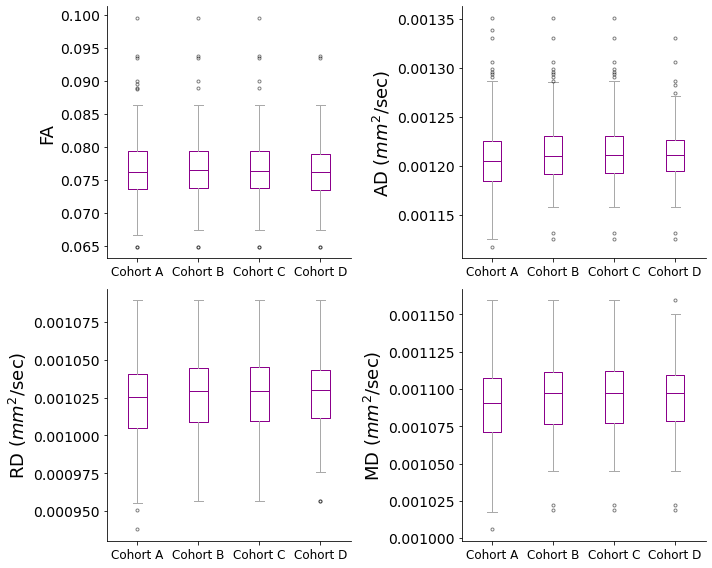

In [113]:
fig, axs = plt.subplots(2,2, figsize=(10,8))
axs = axs.ravel()

for i, metric in enumerate(metrics):
    values = []
    
    for cohort in cohorts.keys():
        #print('Cohort {}:'.format(cohort))
    
        sub_df = df[df.subject_id.isin(cohorts[cohort])]
        values.append([sub_df[metric].values]) 
    
    for p,val in enumerate(values):
        bpl = axs[i].boxplot(list(val[0]), positions=[p],sym='.', widths=0.3, vert=True, showfliers=True,)
        set_box_color(bpl, 'darkmagenta')
        
        if metric in ['RD', 'MD']:
            label = metric + ' ($mm^2$/sec)'
        elif metric == 'L1':
            label = 'AD ($mm^2$/sec)'
        else: 
            label = metric
        axs[i].set_ylabel(label, fontsize=18)
        axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].set_xticklabels( ['Cohort {}'.format(cohort) for cohort in cohorts.keys()], fontsize=12)    
    
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.set_facecolor("white")
plt.tight_layout() 
#plt.savefig('../../Results/figures/cohort_descriptions/diffusion_metrics_distribution_median.png', dpi=500)
plt.show()

Hippocampus segmentation missing for some subjects: 

In [114]:
test = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric.csv', index_col=0)
miss_hippo = test[(test['left_118_FA'].isna()) | test['right_117_FA'].isna()  ]['subject_id'].values
df[df.subject_id.isin(miss_hippo)][['subject_id', 'session_id_x', 'GA_birth', 'PMA_scan']]

,subject_id,session_id_x,GA_birth,PMA_scan
88,CC00245BN15,82600,31.714286,35.14
199,CC00492BN15,140800,35.142857,36.57
267,CC00660XX09,215900,37.857143,42.43


# Plotting the correction for PMA at scan